In [59]:
import pdb, math
import matplotlib.pyplot as plt
import numpy as np
import torch
import pdb
plt.rcParams["figure.figsize"] = (12,12)

In [60]:
H = 300
W = 300

ORIGIN = torch.from_numpy(np.array([0,0,-5]))

EPSILON = 0.01
INNER_STEP = .01

class DetectorSquare():
    def __init__(self, origin, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)

# origin is at -5, getector is at 5 placing objects in the middle        
detector = DetectorSquare(ORIGIN, h=H, w=W, z=5)

In [61]:
#rays from origin to corresponding point on the detector place

rays = np.stack((detector.xes[:,None].repeat(detector.h,axis=1), 
                 detector.yes[:,None].repeat(detector.w,axis=1).transpose(), 
                 torch.zeros((detector.w,detector.h))))

#to torch
rays = torch.from_numpy(rays).float()

In [62]:
#unit vectors from origin to detector plane
vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float()

In [63]:
#starting positions over every vector
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()

In [64]:
#placeholders
energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()

In [73]:
def sphereSDF_torch(points,_):
    
    return torch.norm(points) - torch.tensor(0.5)


def torch_displance_point_along_vector(rays0, vectors, distances):
    def norm(vectors): return torch.sqrt((vectors).pow(2).sum(0))
    return rays0[:,None,None] + (vectors / norm(vectors))*distances

In [74]:
while True:
    min_distance = sphereSDF_torch(current_points,_)
    
    current_points = torch.where(min_distance>EPSILON, 
                              torch_displance_point_along_vector(ORIGIN.float(), vectors.float(), range_map.float()+min_distance.float()), 
                              torch_displance_point_along_vector(ORIGIN.float(), vectors.float(), range_map.float()+torch.tensor(INNER_STEP)))
    
    range_map  += torch.where(min_distance>EPSILON, min_distance, torch.tensor(INNER_STEP))
    energy_map += torch.where(min_distance>EPSILON, torch.tensor(0.), torch.tensor(1.))
    
    if min_distance.min()>10: break

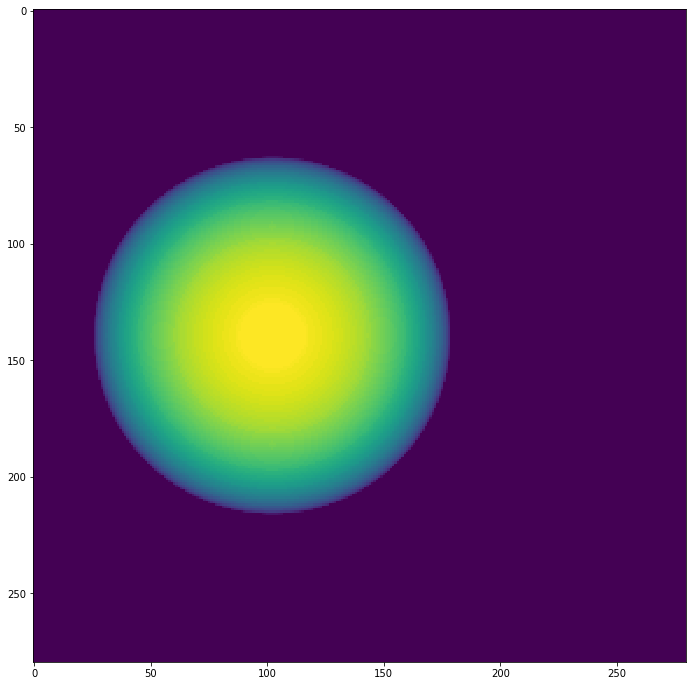

In [75]:
plt.imshow(energy_map[10:-10,10:-10])
plt.show()

In [76]:
%timeit range_map.float()+min_distance.float()

8.86 µs ± 6.92 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [77]:
%timeit ORIGIN.float()

2.03 µs ± 21.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [78]:
%timeit min_distance>EPSILON

4.92 µs ± 35.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [84]:
%timeit torch.norm(current_points)

243 µs ± 811 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
%timeit torch.where(min_distance>EPSILON, min_distance, torch.tensor(INNER_STEP))

10.8 µs ± 71.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [81]:
%timeit torch.where(min_distance>EPSILON, torch.tensor(0.), torch.tensor(1.))

12.3 µs ± 53.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
def timeme():
    #unit vectors from origin to detector plane
    vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float()
    #starting positions over every vector
    current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()
    #placeholders
    energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
    range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
    while True:
        min_distance = sphereSDF_torch(current_points,_)
        current_points = torch.where(min_distance>EPSILON, 
                                  torch_displance_point_along_vector(ORIGIN.float(), vectors.float(), range_map.float()+min_distance.float()), 
                                  torch_displance_point_along_vector(ORIGIN.float(), vectors.float(), range_map.float()+torch.tensor(INNER_STEP)))
        range_map  += torch.where(min_distance>EPSILON, min_distance, torch.tensor(INNER_STEP))
        energy_map += torch.where(min_distance>EPSILON, torch.tensor(0.), torch.tensor(1.))
        if min_distance.min()>10: break

In [58]:
%timeit timeme()

129 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
